<font size=6>**Credit Risk Analysis**</font>

In [5]:
# general imports
import pandas as pd
import zipfile
import numpy as np
import seaborn as sns
from scipy import stats
import scorecardpy as sc
import matplotlib.pyplot as plt
%matplotlib inline
import math

# sklearn imports
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, confusion_matrix, mean_squared_error, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

<font size=4>**Importing the Data set**</font>

In [7]:
zf = zipfile.ZipFile('Lending Club Data.zip')
df = pd.read_csv('Lending Club Data/LCFinal.csv')
LGD_df = df.copy(deep=True)
PD_df = df.copy(deep=True)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (1,17,47,56,115,126,127,128,131,132,133,136,142,143,144) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


**Defining some functions:**

woe_trans: Performs Weight of Assets transformation on a dataframe. Returns the train and test WoE, train and test sets, and the bins.

heat_map: Creates a heatmap of the confusion matrix. 

auc_roc: Create an ROC curve and output the AUC. 

In [8]:
### FUNCTIONS ###
def woe_trans(df, y, ratio=0.7):
  """
  Take a DataFrame and an objective variable, and splits into train and test. 
  Performs woe transformation on splits.
  Returns the woe transformed train and test splits as well as bins
  """
  train, test = sc.split_df(df, y,
                                  ratio = ratio, 
                                  seed = 0).values()

  bins = sc.woebin(train, y, 
                   min_perc_fine_bin=0.01, # How many bins to cut initially into
                   min_perc_coarse_bin=0.01,  # Minimum percentage per final bin
                   stop_limit=0.1, # Minimum information value 
                   max_num_bin=10, # Maximum number of bins
                   method='tree')

  train_woe = sc.woebin_ply(train, bins) # Calculate WoE dataset (train)
  test_woe = sc.woebin_ply(test, bins) # Calculate WoE dataset (test)

  return train_woe, test_woe, train, test, bins

def heat_map(y, y_pred, axis):
    """
    Takes the true y and predicted y values, and an axis to output a heatmap of the confusion matrix produced.
    """
    # Calculate confusion matrix
    confusion_m = confusion_matrix(y, y_pred)

    # Turn matrix to percentages
    confusion_m = confusion_m.astype('float') / confusion_m.sum(axis=1)[:, np.newaxis]

    # Turn to dataframe
    df_cm = pd.DataFrame(confusion_m, index=axis, columns=axis, )

    # Parameters of the image
    figsize = (10,7)
    fontsize=14

    # Create image
    fig = plt.figure(figsize=figsize)
    heatmap = sns.heatmap(df_cm, annot=True, fmt='.2f')

    # Make it nicer
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, 
                                 ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45,
                                 ha='right', fontsize=fontsize)

    # Add labels
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    # Plot!
    plt.show()

def auc_roc(y_true, y_score):
    """
    Takes the true y value and the y score value to produce an ROC curve and the AUC of the curve.
    """
    # Calculate the ROC curve points
    fpr, tpr, thresholds = roc_curve(y_true, y_score)

    # Save the AUC in a variable to display it. Round it first
    auc = np.round(roc_auc_score(y_true, y_score),
                   decimals = 3)

    # Create and show the plot
    plt.plot(fpr,tpr,label="PD, auc="+str(auc))
    plt.legend(loc=4)
    plt.show()

**Cleaning the Data**

Data set contains 2,260,701 observation and 148 attributes. Not all observations are complete (i.e. many non-values) and many attributes are sparse (i.e. mostly NaN values), non-predictive (e.g. member_id), or illegal (e.g. zip_code).

Two datasets needed to be individually cleaned. One for Probability of Default (0 or 1 integer) and one for Loss Given Default (0-1 float). 

In [9]:
###---PD DataFrame: Dropping Columns---###
# removing columns with irrelevant data points (i.e. member_id or url)
PD_df = PD_df.drop(['Unnamed: 0', 'member_id', 'url', 'id', 'desc', 
              'hardship_flag', 'pymnt_plan', ], axis='columns')

# remove columns containing data that would not be available prior to giving a loan
PD_df = PD_df.drop(['last_fico_range_high', 'last_fico_range_low', 'tot_cur_bal', 
              'mths_since_rcnt_il', 'mo_sin_rcnt_rev_tl_op', 
              'mths_since_recent_inq', 'avg_cur_bal', 'mo_sin_rcnt_tl', 
              'mths_since_recent_bc', 'delinq_2yrs', 
              'out_prncp', 'total_rec_late_fee', 'recoveries', 
              'collections_12_mths_ex_med', 'acc_now_delinq', 'tot_coll_amt',
              'chargeoff_within_12_mths', 'delinq_amnt', 'num_accts_ever_120_pd',
              'num_tl_120dpd_2m', 'num_tl_30dpd', 'num_tl_90g_dpd_24m',
              'funded_amnt', 'funded_amnt_inv', 'out_prncp_inv', 
              'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 
              'collection_recovery_fee', 'last_pymnt_amnt', 'total_rev_hi_lim',
              'acc_open_past_24mths', 'bc_open_to_buy', 'bc_util', 
              'mths_since_recent_revol_delinq', 'num_actv_bc_tl', 
              'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 
              'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 
              'num_sats', 'num_tl_op_past_12m', 'pct_tl_nvr_dlq', 
              'percent_bc_gt_75', 'tax_liens', 'total_bal_ex_mort', 
              'total_bc_limit', 'total_il_high_credit_limit',
              'debt_settlement_flag', 'mths_since_last_delinq',
              'revol_util', 'mo_sin_old_rev_tl_op', 'mo_sin_old_il_acct'], axis='columns')

# removing columns with difficult to work with data points
PD_df = PD_df.drop(['emp_title', 'purpose', 'title'], axis='columns')

# removing columns that contain data pertaining to identity and not behaviour
PD_df = PD_df.drop(['zip_code', 'addr_state'], axis='columns')

# remove columns where most of the data (>50%) is None
PD_df = PD_df.dropna(thresh=len(PD_df)*0.5, axis='columns')

# remove columns where most of the data points are the same
PD_df = PD_df.drop(['application_type', 'initial_list_status',
              'disbursement_method'], axis='columns')

# remove all date columns
PD_df = PD_df.drop(['issue_d', 'earliest_cr_line', 'last_pymnt_d', 'last_credit_pull_d'], axis='columns')

# remove highly correlated values
corr_matrix = PD_df.corr() # create a correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool)) # obtain only the upper triangle of the matrix
to_drop = [column for column in upper.columns if any(upper[column] > 0.5)] # get column names with features with greater than 0.5 correlation
PD_df = PD_df.drop(to_drop, axis='columns') # drop columns

###---PD DataFrame: Removing Rows---###
# remove rows that are missing >35% of variables
PD_df = PD_df.dropna(axis='rows', how='any', thresh=len(PD_df.columns)-len(PD_df.columns)*0.35)

###---PD DataFrame: Cleaning Up Data---###
# convert employment length from string to integers
PD_df.loc[PD_df.emp_length == '10+ years', 'emp_length'] = '10 years' # make 10+ to 12 years
PD_df.loc[PD_df.emp_length == '< 1 year', 'emp_length'] = '0 year' # round up <1 year to 1 year
temp = PD_df.emp_length # create temporary list of employment length
temp = temp.fillna('0') # get rid of null values in place of 0 as a string
temp = [x.strip(' year') for x in temp] # strip 'year' from strings
temp = [x.strip(' years') for x in temp] # strip 'years' from strings
PD_df.emp_length = [int(x) for x in temp] # return integer values back into the dataframe

# fill in missing values
PD_df['dti'] = PD_df['dti'].fillna(np.median(df.dti))
PD_df = PD_df.fillna(0)

# adjust outliers
PD_df = PD_df.loc[(PD_df['annual_inc'] < 300000) & (PD_df['dti'] < 60) & 
                  (PD_df['revol_bal'] < 100000) & (PD_df['mort_acc'] < 10)]

s = stats.iqr(PD_df.open_acc, interpolation = 'midpoint')/(2*0.6745)
PD_df.loc[PD_df.open_acc > np.median(PD_df.open_acc)+3*s, 'open_acc'] = np.median(PD_df.open_acc)+3*s

In [0]:
###---Cleaning LGD DataFrame---###
# Calculating LGD column
LGD_df['LGD'] = (LGD_df.loan_amnt - LGD_df.total_pymnt - LGD_df.tot_coll_amt)/LGD_df.loan_amnt * 100
LGD_df.loc[LGD_df.LGD < 0, 'LGD'] = 0 # change all 'negative' LGDs to 0

###---LGD DataFrame: Dropping Columns---###
# removing columns with irrelevant data points (i.e. member_id or url)
LGD_df = LGD_df.drop(['Unnamed: 0', 'member_id', 'url', 'id', 'desc', 
                      'hardship_flag', 'pymnt_plan', ], axis='columns')

LGD_df = LGD_df.drop(['mths_since_rcnt_il', 'mo_sin_rcnt_rev_tl_op', 
              'mths_since_recent_inq', 'avg_cur_bal', 'mo_sin_rcnt_tl', 
              'mths_since_recent_bc', 'delinq_2yrs', 
              'out_prncp', 'total_rec_late_fee', 'recoveries', 
              'collections_12_mths_ex_med', 'acc_now_delinq',
              'chargeoff_within_12_mths', 'delinq_amnt', 'num_accts_ever_120_pd',
              'num_tl_120dpd_2m', 'num_tl_30dpd', 'num_tl_90g_dpd_24m',
              'funded_amnt', 'funded_amnt_inv', 'out_prncp_inv', 
              'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 
              'collection_recovery_fee', 'last_pymnt_amnt', 'total_rev_hi_lim',
              'acc_open_past_24mths', 'bc_open_to_buy', 
              'mths_since_recent_revol_delinq', 'num_actv_bc_tl', 
              'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 
              'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 
              'num_sats', 'num_tl_op_past_12m', 'pct_tl_nvr_dlq', 
              'percent_bc_gt_75', 'tax_liens', 'total_bal_ex_mort', 
              'total_bc_limit', 'total_il_high_credit_limit',
              'debt_settlement_flag', 'mths_since_last_delinq',
              'revol_util', 'mo_sin_old_rev_tl_op', 'mo_sin_old_il_acct',
              'emp_length', 'revol_bal', 'open_acc', 'tot_hi_cred_lim', 
              'term', 'home_ownership', 
              'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m', 
              'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m', 
              'max_bal_bc', 'total_cu_tl', 'inq_last_12m', 'inq_fi'], axis='columns')

# removing columns with difficult to work with data points
LGD_df = LGD_df.drop(['emp_title', 'purpose', 'title'], axis='columns')

# removing columns that contain data pertaining to identity and not behaviour
LGD_df = LGD_df.drop(['zip_code', 'addr_state'], axis='columns')

# remove columns where most of the data (>50%) is None
LGD_df = LGD_df.dropna(thresh=len(LGD_df)*0.5, axis='columns')

# remove columns where most of the data points are the same
LGD_df = LGD_df.drop(['application_type', 'initial_list_status',
              'disbursement_method'], axis='columns')

# remove all date columns
LGD_df = LGD_df.drop(['issue_d', 'earliest_cr_line', 'last_pymnt_d', 'last_credit_pull_d'], axis='columns')

# remove highly correlated values
corr_matrix = LGD_df.corr() # create a correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool)) # obtain only the upper triangle of the matrix
to_drop = [column for column in upper.columns if any(upper[column] > 0.5)] # get column names with features with greater than 0.5 correlation
LGD_df = LGD_df.drop(['fico_range_high', 'pub_rec', 'last_fico_range_high', 
                      'mort_acc', 'pub_rec_bankruptcies', 
                      'inq_last_6mths', 'total_acc'], axis='columns')


###---LGD DataFrame: Dropping Rows---###
# remove rows that are missing >35% of variables
LGD_df = LGD_df.dropna(axis='rows', how='any', thresh=len(LGD_df.columns)-len(LGD_df.columns)*0.35)

###---LGD DataFrame: Cleaning Data---###
# fill in missing values
LGD_df['dti'] = LGD_df['dti'].fillna(np.median(LGD_df.dti))
LGD_df = LGD_df.fillna(0)

## Adjust Outliers ##
LGD_df = LGD_df.loc[(LGD_df['annual_inc'] < 300000) & (LGD_df['dti'] < 60)]


In [27]:
###---PD Dataframe: Additional Cleaning---###
# remove rows with loan status that is not 'Fully Paid' or 'Charged Off'
PD_df = PD_df[df['loan_status'].isin(['Fully Paid', 'Charged Off'])]

# convert loan status to integer values of 1 or 0 (Fully Paid or Charged Off respectively)
PD_df.loc[PD_df.loan_status == 'Fully Paid', 'loan_status'] = 0
PD_df.loc[PD_df.loan_status == 'Charged Off', 'loan_status'] = 1

###---LGD Dataframe: Additional Cleaning---###
# remove rows with loan status that is not 'Charged Off'
LGD_df_extra = LGD_df[LGD_df['loan_status'].isin(['Charged Off']) == False]
LGD_df = LGD_df[LGD_df['loan_status'].isin(['Charged Off'])]

# drop the loan status column
LGD_df = LGD_df.drop('loan_status', axis='columns')
LGD_df_extra = LGD_df_extra.drop('loan_status', axis='columns')

# group LGD values into groups of 10
LGD_df.LGD = [math.ceil(x/10) * 10 for x in LGD_df.LGD]
LGD_df.loc[LGD_df.LGD == 0, 'LGD'] = 10

LGD_df_extra.LGD = [math.ceil(x/10) * 10 for x in LGD_df_extra.LGD]
LGD_df_extra.loc[LGD_df_extra.LGD == 0, 'LGD'] = 10

# create dummy variables
LGD_df = pd.get_dummies(LGD_df, drop_first=True)
LGD_df_extra = pd.get_dummies(LGD_df_extra, drop_first=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


**Weight of Evidence Transformation for Probability of Default DataFrame**

In [39]:
###---Weight of Evidence Transformation---###
PD_train_woe, PD_test_woe, PD_train, PD_test, PD_bins = woe_trans(PD_df, 'loan_status') # calling the woe transformation function

PD_train_woe_iv = sc.iv(PD_train_woe, 'loan_status')

# drop variables that have extremely low IV (<0.02)
PD_train_woe_iv = PD_train_woe_iv.loc[PD_train_woe_iv['info_value'] < 0.02]
PD_train_woe_iv.variable = [x[:-4] for x in PD_train_woe_iv.variable]
PD_df = PD_df.drop(PD_train_woe_iv.variable.values, axis='columns')

PD_train_woe, PD_test_woe, PD_train, PD_test, PD_bins = woe_trans(PD_df, 'loan_status') # calling the woe transformation function

# sc.woebin_plot(PD_bins) # Plots the different bins
sc.iv(PD_train_woe, 'loan_status')


[INFO] creating woe binning ...
Binning on 922509 rows and 19 columns in 00:01:07
[INFO] converting into woe values ...
Woe transformating on 922509 rows and 18 columns in 00:00:38
[INFO] converting into woe values ...
Woe transformating on 395362 rows and 18 columns in 00:00:19
[INFO] creating woe binning ...
Binning on 922509 rows and 11 columns in 00:00:38
[INFO] converting into woe values ...
Woe transformating on 922509 rows and 10 columns in 00:00:23
[INFO] converting into woe values ...
Woe transformating on 395362 rows and 10 columns in 00:00:11


,variable,info_value
9,int_rate_woe,0.430817
0,term_woe,0.176420
8,fico_range_low_woe,0.118474
3,dti_woe,0.070350
6,loan_amnt_woe,0.032959
4,mort_acc_woe,0.031647
2,home_ownership_woe,0.029736
5,inq_last_6mths_woe,0.026661
1,annual_inc_woe,0.024375
7,open_acc_6m_woe,0.020965


**Logistic Regression Model to Predict Probability of Default**

Create a logistic regressino model and fit it using the weight of evidence transformation. A confusion matrix and an ROC curve is created to evaluate the performance of the model. 

In [40]:
###---Logistic Regression Model---###
PD_logreg = LogisticRegression(penalty='l1', # Type of penalization l1 = lasso, l2 = ridge
                               tol=1e-8, # Tolerance for parameters
                               C=0.02, # Penalty constant
                               fit_intercept=True,
                               class_weight='balanced', # Weights
                               random_state=0, # Random seed
                               max_iter=20409, # Maximum iterations
                               verbose=1, # Show process
                               solver = 'saga',
                               warm_start=False)

# fit the model
PD_logreg.fit(X = PD_train_woe.drop(['loan_status'], axis='columns'), 
              y = PD_train_woe['loan_status']) # The target

# get coefficients
coef_df = pd.concat([pd.DataFrame({'column': PD_train_woe.columns[1:]}), 
                    pd.DataFrame(np.transpose(PD_logreg.coef_))],
                    axis = 1)

pred_class_test = PD_logreg.predict(PD_test_woe.drop('loan_status', axis='columns'))
probs_test = PD_logreg.predict_proba(PD_test_woe.drop('loan_status', axis='columns'))


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 43 epochs took 27 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   27.8s finished


,column,0
0,int_rate_woe,0.641168
1,term_woe,0.632787
2,fico_range_low_woe,0.488080
3,home_ownership_woe,0.632978
4,annual_inc_woe,0.646504
5,dti_woe,0.578319
6,open_acc_6m_woe,0.914884
7,mort_acc_woe,0.587392
8,inq_last_6mths_woe,0.402622
9,loan_amnt_woe,0.518734


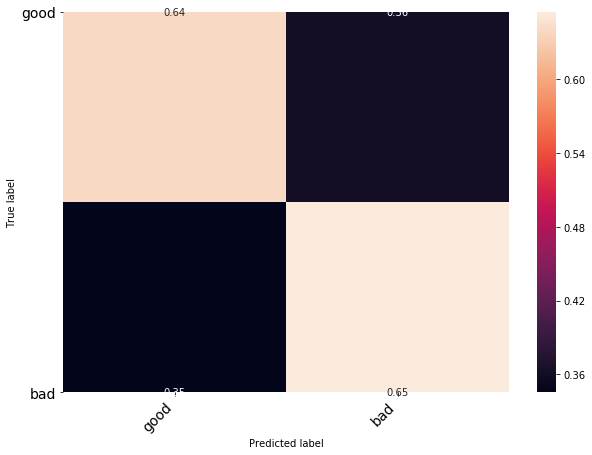

In [41]:
heat_map(PD_test['loan_status'], pred_class_test, axis=['good', 'bad'])

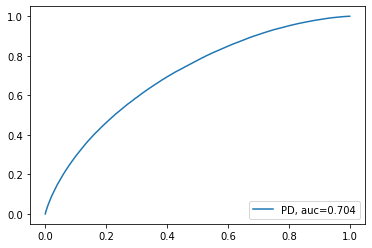

In [43]:
auc_roc(PD_test['loan_status'], probs_test[:,1])

**Probability of Default Scorecard**

Socrecard for probability of default created using the WoE bins and the logistic regression model created

In [0]:
###---PD Scorecard---###
PD_sc = sc.scorecard(PD_bins, PD_logreg, 
             PD_train_woe.columns[1:], # The column names in the trained LR
             points0=600, # Base points
             odds0=0.01, # Base odds
             pdo=50) # PDO 

# Applying the credit score. Applies over the original data!
train_score = sc.scorecard_ply(PD_train, PD_sc, 
                               print_step=0)
test_score = sc.scorecard_ply(PD_test, PD_sc, 
                               print_step=0)

test_score.describe()

**Random Forest Model for Loss Given Default**

In [30]:
###---LGD Random Forest Model---###
LGD_train, LGD_test = sc.split_df(LGD_df, 'LGD',
                                  ratio = 0.7, 
                                  seed = 0).values()

# create model
LGD_rf = RandomForestClassifier(n_estimators=1000, # Number of trees to train
                       max_depth=None, # Max depth of the trees
                       min_samples_split=2, # Minimum samples to create a split.
                       min_samples_leaf=0.001, # Minimum samples in a leaf
                       min_weight_fraction_leaf=0.001, 
                       max_features='auto', # Maximum number of features per split
                       max_leaf_nodes=None, # Maximum number of nodes
                       min_impurity_decrease=0.0001, # Minimum impurity decrease
                       bootstrap=False, # 
                       n_jobs=-1, # Parallel processing
                       random_state=0, # Seed
                       verbose=1, 
                       warm_start=False,
                       class_weight='balanced')

# fit model
LGD_rf.fit(X = LGD_train.drop('LGD', axis='columns'), 
           y = LGD_train['LGD'])

# Apply the model to the test set.
rf_pred_class_test = LGD_rf.predict(LGD_test.drop('LGD', axis='columns'))
rf_probs_test = LGD_rf.predict_proba(LGD_test.drop('LGD', axis='columns'))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   29.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  2.6min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    2.8s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    3.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.7s


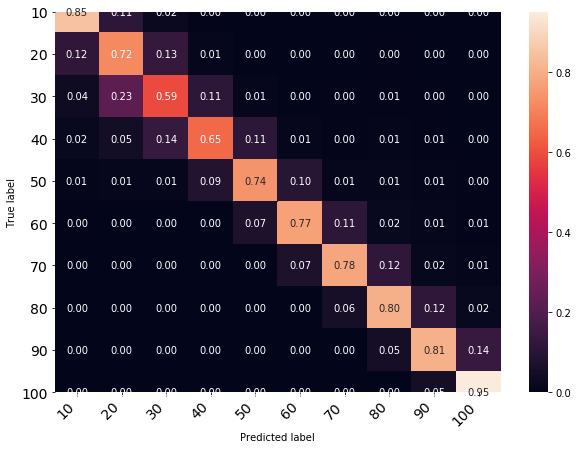

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   15.6s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   35.4s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:  1.0min


[10 30 10 ... 40 30 40]


[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:  1.3min finished


In [35]:
heat_map(LGD_test['LGD'], rf_pred_class_test, np.arange(10,110, 10))
print(LGD_rf.predict(LGD_df_extra.drop('LGD', axis='columns')))

In [32]:
# variable importance
for name, importance in zip(LGD_train.drop(['LGD'], axis='columns').columns, LGD_rf.feature_importances_):
  print(name, "= %.2f" % importance)

loan_amnt = 0.21
int_rate = 0.01
installment = 0.11
annual_inc = 0.01
dti = 0.00
fico_range_low = 0.01
total_pymnt = 0.55
last_fico_range_low = 0.01
tot_coll_amt = 0.02
tot_cur_bal = 0.03
all_util = 0.05
bc_util = 0.00


In [ ]:
print(f"Average LGD of non-defaulted loans using RF model: {np.mean(LGD_rf.predict(LGD_df_extra.drop('LGD', axis='columns')))}")

**XGBoosted Model for Loss Given Default**

In [33]:
# create model
LGD_xg = GradientBoostingClassifier(loss='deviance', 
                           learning_rate=0.1, # How much to shrink error in each subsequent training
                           n_estimators=100, # How many trees to use
                           subsample=0.632, # Subsampling to use
                           criterion='friedman_mse', # Error to use for each split
                           min_samples_split=2, # Minimum samples for a split
                           min_samples_leaf=1, # Minimum samples in a leaf
                           min_weight_fraction_leaf=0.0, # Minimum fraction of samples in a leaf
                           max_depth=3, # Maximum depth
                           min_impurity_decrease=0.01, # Minimum impurity decrease
                           init=None, 
                           random_state=0, # Seed
                           max_features='auto', 
                           verbose=1,  
                           max_leaf_nodes=None,  
                           warm_start=False,  
                           presort='auto', 
                           validation_fraction=0.3, # to prevent overfitting
                           n_iter_no_change=None, 
                           tol=0.0001 # Tolerance
                          )
# fit model
LGD_xg.fit(LGD_train.drop('LGD', axis='columns'), 
           LGD_train['LGD'])

# Apply the model to the test set.
xg_pred_class_test = LGD_xg.predict(LGD_test.drop('LGD', axis='columns'))
xg_probs_test = LGD_xg.predict_proba(LGD_test.drop('LGD', axis='columns'))


      Iter       Train Loss      OOB Improve   Remaining Time 
         1      236785.6989       11027.2403            4.19m
         2      225486.9201        6578.6063            4.14m
         3      216485.5963        5248.8618            4.11m
         4      207707.4296        5035.8385            4.05m
         5      200859.3378        3973.3807            4.00m
         6      194510.4837        3666.5766            3.96m
         7      189158.1290        3030.9661            3.92m
         8      184415.8718        2840.0746            3.88m
         9      180307.6774        2437.6670            3.84m
        10      175698.9938        2552.8233            3.80m
        20      146785.8658        1761.3484            3.39m
        30      128128.8417         847.1038            2.96m
        40      114602.1499         656.5781            2.54m
        50      105823.5952         461.6204            2.11m
        60       98023.8916         347.8711            1.68m
       

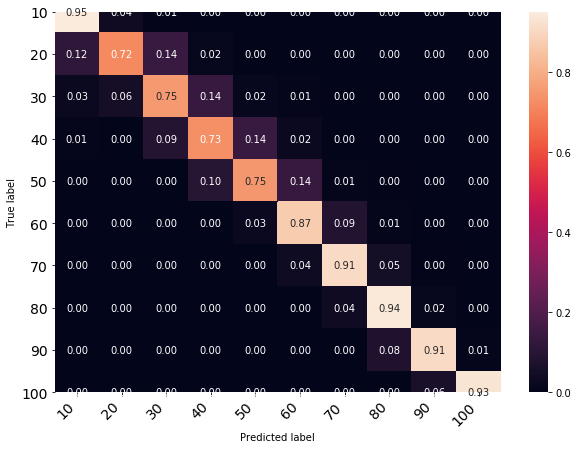

In [34]:
heat_map(LGD_test['LGD'], xg_pred_class_test, np.arange(10,110, 10))

In [22]:
# variable importance
for name, importance in zip(LGD_train.drop(['LGD'], axis='columns').columns, LGD_xg.feature_importances_):
  print(name, "= %.2f" % importance)

loan_amnt = 0.36
int_rate = 0.00
installment = 0.02
annual_inc = 0.00
dti = 0.00
fico_range_low = 0.00
total_pymnt = 0.56
last_fico_range_low = 0.00
tot_coll_amt = 0.03
tot_cur_bal = 0.03
all_util = 0.01
bc_util = 0.00


In [38]:
print(f"Average LGD of non-defaulted loans using XGB model:{np.mean(LGD_xg.predict(LGD_df_extra.drop('LGD', axis='columns')))}")

Average LGD of non-defaulted loans using XGB model:31.025575989920956
